# C S 342 Final Project

## Overview

**Problem/Solution**

The project involves building a neural network to classify hand gestures from American Sign Language (ASL), specifically focusing on the 24 letters of the ASL alphabet (excluding J and Z, as they involve movement). The model aims to facilitate sign language recognition, which can enable individuals to communicate with technology or other people using sign language. Additionally, it could be expanded into touchless human-computer interactions, such as controlling devices or applications through hand gestures.

 **Training Data**

The training data will be sourced from the ~~Sign Language MNIST dataset~~, ASL Alphabet Dataset which contains ~~grayscale 28x28 pixel~~ 200x200 pixel color images of hand gestures representing the 24 letters of the ASL alphabet and labeled with the corresponding ASL letter. ~~The dataset was created by extending a small set of 1,704 uncropped color images. These images were then cropped around the hand region, converted to grayscale, resized, and augmented with over 50 variations per image using filters, random pixelation, brightness/contrast adjustments, and slight rotations. The final dataset includes 27,455 training images and 7,172 test images.~~


**Computational experiments**

Experiment 1 is an ablation study, where we remove or modify different parts of the model (e.g., regularization techniques, CNN layers, dropout, activation functions) to identify which components are most crucial for accurately classifying hand gestures. The goal is to better understand how the model differentiates between gestures and to find any critical features or architectural choices that improve classification performance.

Experiment 2 is a generalization study, in which the model trained on the Sign Language MNIST dataset will be evaluated on a different hand gesture dataset to test its ability to generalize and check for overfitting. If time permits, this experiment will also include testing the model in a real-time setting, where it classifies gestures from processed images captured via a camera feed.


## Loading and Understanding the Dataset

In [342]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from collections import Counter
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Subset
from torch.utils.data import DataLoader

from tqdm import tqdm


In [343]:
# Define training and evaluation data transforms

train_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),             
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

In [344]:
# Load dataset twice for train and eval

data_dir = "ASL Alphabet Dataset"
train_full = ImageFolder(root=data_dir, transform=train_transform)
eval_full = ImageFolder(root=data_dir, transform=eval_transform)
print("Classes:", train_full.classes)
print("Total images:", len(train_full))

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Total images: 166028


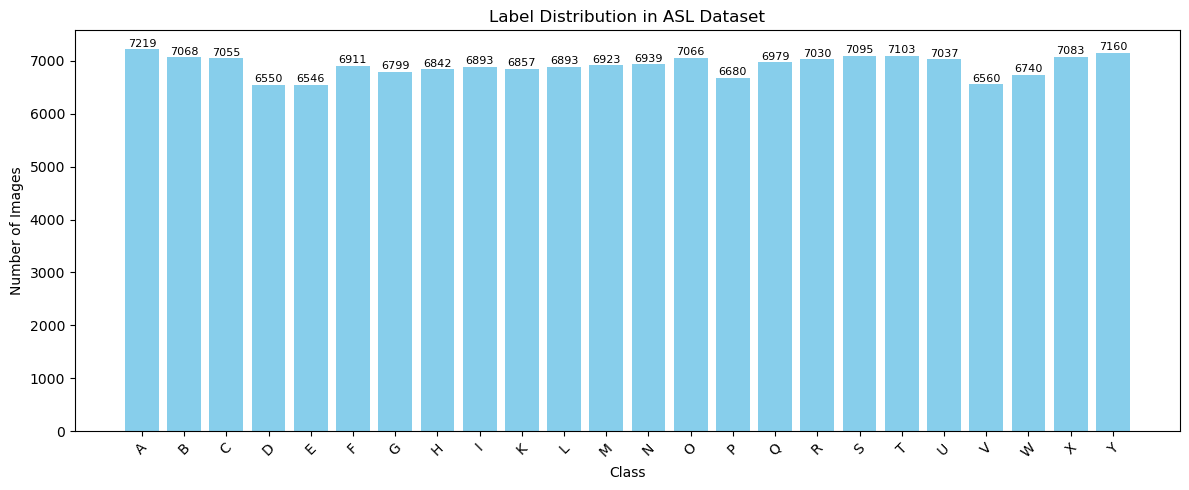

In [345]:
# Plot dataset class distribution

label_counts = Counter(train_full.targets)
counts = list(label_counts.values())
classes = [train_full.classes[i] for i in label_counts.keys()]

plt.figure(figsize=(12, 5))
bars = plt.bar(classes, counts, color="skyblue")
plt.title("Label Distribution in ASL Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, str(height),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [346]:
# Split dataset into train, validation, and test sets

train_size = int(0.7 * len(train_full))
val_size = int(0.15 * len(train_full))
test_size = len(train_full) - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    train_full, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

val_ds = Subset(eval_full, val_ds.indices)
test_ds = Subset(eval_full, test_ds.indices)

In [347]:
# Create DataLoaders

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)


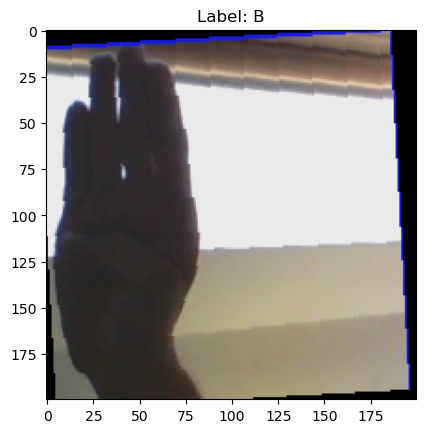

In [348]:
# Show a sample image

def imshow(img, title=""):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(images[0], title=f"Label: {train_full.classes[labels[0]]}")

## Training the Model

In [349]:
# Set device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [350]:
# Define training function

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [351]:
# Define validation / testing function

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [352]:
# Define our model

class ASLCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # (32, 100, 100)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # (64, 50, 50)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # (128, 25, 25)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),  # (256, 12, 12)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 12 * 12, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [353]:
# Instantiate training parameters 

model = ASLCNN(num_classes=len(train_full.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [354]:
# Train and save best model

epochs = 10
best_val_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved new best model.")



Epoch 1/10


100%|██████████| 3632/3632 [04:49<00:00, 12.55it/s]


Train Loss: 2.7255, Train Acc: 0.1422
Val   Loss: 1.5779, Val   Acc: 0.4462
✅ Saved new best model.

Epoch 2/10


100%|██████████| 3632/3632 [04:58<00:00, 12.18it/s]


Train Loss: 1.2992, Train Acc: 0.5457
Val   Loss: 0.4799, Val   Acc: 0.8327
✅ Saved new best model.

Epoch 3/10


100%|██████████| 3632/3632 [04:49<00:00, 12.54it/s]


Train Loss: 0.6175, Train Acc: 0.7912
Val   Loss: 0.2022, Val   Acc: 0.9367
✅ Saved new best model.

Epoch 4/10


100%|██████████| 3632/3632 [04:48<00:00, 12.57it/s]


Train Loss: 0.3891, Train Acc: 0.8721
Val   Loss: 0.1496, Val   Acc: 0.9534
✅ Saved new best model.

Epoch 5/10


100%|██████████| 3632/3632 [05:15<00:00, 11.51it/s]


Train Loss: 0.2904, Train Acc: 0.9062
Val   Loss: 0.0875, Val   Acc: 0.9741
✅ Saved new best model.

Epoch 6/10


100%|██████████| 3632/3632 [05:10<00:00, 11.72it/s]


Train Loss: 0.2380, Train Acc: 0.9250
Val   Loss: 0.0998, Val   Acc: 0.9682

Epoch 7/10


100%|██████████| 3632/3632 [05:00<00:00, 12.07it/s]


Train Loss: 0.1998, Train Acc: 0.9376
Val   Loss: 0.1021, Val   Acc: 0.9674

Epoch 8/10


100%|██████████| 3632/3632 [04:56<00:00, 12.24it/s]


Train Loss: 0.1806, Train Acc: 0.9437
Val   Loss: 0.0424, Val   Acc: 0.9872
✅ Saved new best model.

Epoch 9/10


100%|██████████| 3632/3632 [04:54<00:00, 12.31it/s]


Train Loss: 0.1654, Train Acc: 0.9507
Val   Loss: 0.0407, Val   Acc: 0.9883
✅ Saved new best model.

Epoch 10/10


100%|██████████| 3632/3632 [04:51<00:00, 12.45it/s]


Train Loss: 0.1503, Train Acc: 0.9552
Val   Loss: 0.0671, Val   Acc: 0.9815


In [355]:
# Evaluate model on test set

model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"\n🧪 Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


C:\Users\ExoHorizon\AppData\Local\Temp\ipykernel_36652\2456452720.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



🧪 Test Loss: 0.0402, Test Accuracy: 0.9872


## Experiment 1: Ablation Study

## Experiment 2: Generalization Study

In [356]:
# Load new dataset

transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])

new_data_dir = "Generalizability Dataset\ASL_Dataset\Train"
new_dataset = datasets.ImageFolder(root=new_data_dir, transform=transform)

print("Classes:", new_dataset.classes)
print("Total images:", len(new_dataset))

new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
Total images: 141796


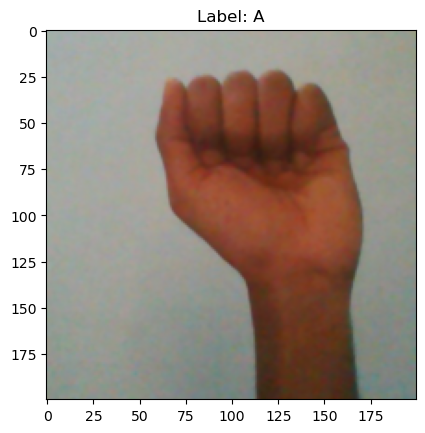

In [357]:
# Show a sample image from new dataset

dataiter = iter(new_loader)
images, labels = next(dataiter)
imshow(images[0], title=f"Label: {new_dataset.classes[labels[0]]}")

In [358]:
# Test model generalizability on new dataset

new_loss, new_acc = evaluate(model, new_loader, criterion)

print(f"Loss on new dataset: {new_loss:.4f}")
print(f"Accuracy on new dataset: {new_acc:.4f}")

Loss on new dataset: 2.5684
Accuracy on new dataset: 0.7151
